# CSI 4142 Deliverable 4


## Imports & Constants


In [357]:
import numpy as np
import pandas as pd
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import classification_report, confusion_matrix

import psycopg2
from psycopg2.extras import RealDictCursor
from psycopg2 import Error

# Change these to whatever values you need
PSQL_PASS = "mysecretpassword"
PSQL_HOST = "localhost"
PSQL_PORT = "5432"
PSQL_USER = "postgres"
PSQL_DB = "postgres"

COLS = [
    # From Population Dim 
    "Population growth (annual %)",
    "Life expectancy at birth, total (years)",
    "Suicide mortality rate (per 100,000 population)",
    "Urban population (% of total population)",
    "Rural population (% of total population)",
    "Population ages 65 and above (% of total population)",

    # From Health Dim  
    "Domestic general government health expenditure (% of GDP)",
    "Physicians (per 1,000 people)",
    "Hospital beds (per 1,000 people)",
    "Prevalence of undernourishment (% of population)",
    "Prevalence of overweight, male (% of male adults)",
    "Prevalence of overweight, female (% of female adults)",

    # From Country Dim 
    "Birth rate, crude (per 1,000 people)",
    "Population, total",
    "Death rate, crude (per 1,000 people)",
    "Age dependency ratio (% of working-age population)",
    "GNI per capita, Atlas method (current US$)",
    "Fertility rate, total (births per woman)",

    # From QOL Dim
    "Unemployment, total (% of total labor force)",
    "Prevalence of hypertension (% of adults ages 30-79)"
]

QUERY = """
        select distinct p.*, h.*, q.*, c.*, f."Human Development Index" 
        from population p, fact f, health h, country c, qol q
        where p.population_key = f.population_key and h.health_key = f.health_key and c.country_key = f.country_key and q.qol_key = f.qol_key;
        """
LABELS = ['low human development', 'medium human development', 'high human development', 'very high human development']


## Getting Base DataFrame from Server 

In [349]:
with psycopg2.connect(user=PSQL_USER,
                      password=PSQL_PASS,
                      host=PSQL_HOST,
                      port=PSQL_PORT,
                      database=PSQL_DB) as connection:
    with connection.cursor(cursor_factory=RealDictCursor) as cursor:
        cursor.execute(QUERY)
        base_df = pd.DataFrame(cursor.fetchall())

## Preprocessing Data

In [430]:
# Create a Pipeline for the data
# Impute -1 with the median of the column
# Scale the data with a standard scaler
data_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=-1.0)),
    ('scaler', StandardScaler()
     )])

# Created a Pipeline for the labels
# Impute -1s with the median of the column
label_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=-1.0)),
])

# Removing any unwanted columns & isolating target feature.
base_X, base_y = base_df[COLS], base_df["Human Development Index"]

base_y = label_transformer.fit_transform(np.asarray(base_y).reshape(-1,1))

# Making the 'Human Development Index' into labels based on the following resource:
# https://hdr.undp.org/en/content/human-development-report-2020-readers-guide#:~:text=Human%20development%20classification&text=The%20cutoff%2Dpoints%20are%20HDI,for%20very%20high%20human%20development.
base_y = pd.cut(base_y.ravel(), bins=[0, 0.55, 0.7, 0.8, np.inf], labels=LABELS)
base_y.name = "HDI"

# Splitting Data into train, test sets (using a 65% train and 35% test)
__X_train, __X_test, __y_train, __y_test = train_test_split(
    base_X, base_y, test_size=0.35)

X_train = data_transformer.fit_transform(__X_train)
X_test = data_transformer.transform(__X_test)

__y_train = __y_train.to_numpy().reshape(-1, 1)
__y_test = __y_test.to_numpy().reshape(-1, 1)

#OrdinalEncode with the categories: 'low human development', 'medium human development', 'high human development', 'very high human development'
ordEnc = OrdinalEncoder(categories=[LABELS])

y_train = ordEnc.fit_transform(__y_train).ravel()
y_test = ordEnc.transform(__y_test).ravel()


## Some Plots 

### Box Plots
#### With Missing Points (-1s)

C:\Users\Kareem\AppData\Local\Temp/ipykernel_11860/2029422043.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suicide_mortality["Suicide mortality rate (per 100,000 population)"] = suicide_mortality["Suicide mortality rate (per 100,000 population)"].astype(float)


<AxesSubplot:title={'center':'Suicide mortality rate (per 100,000 population)'}, xlabel='country'>

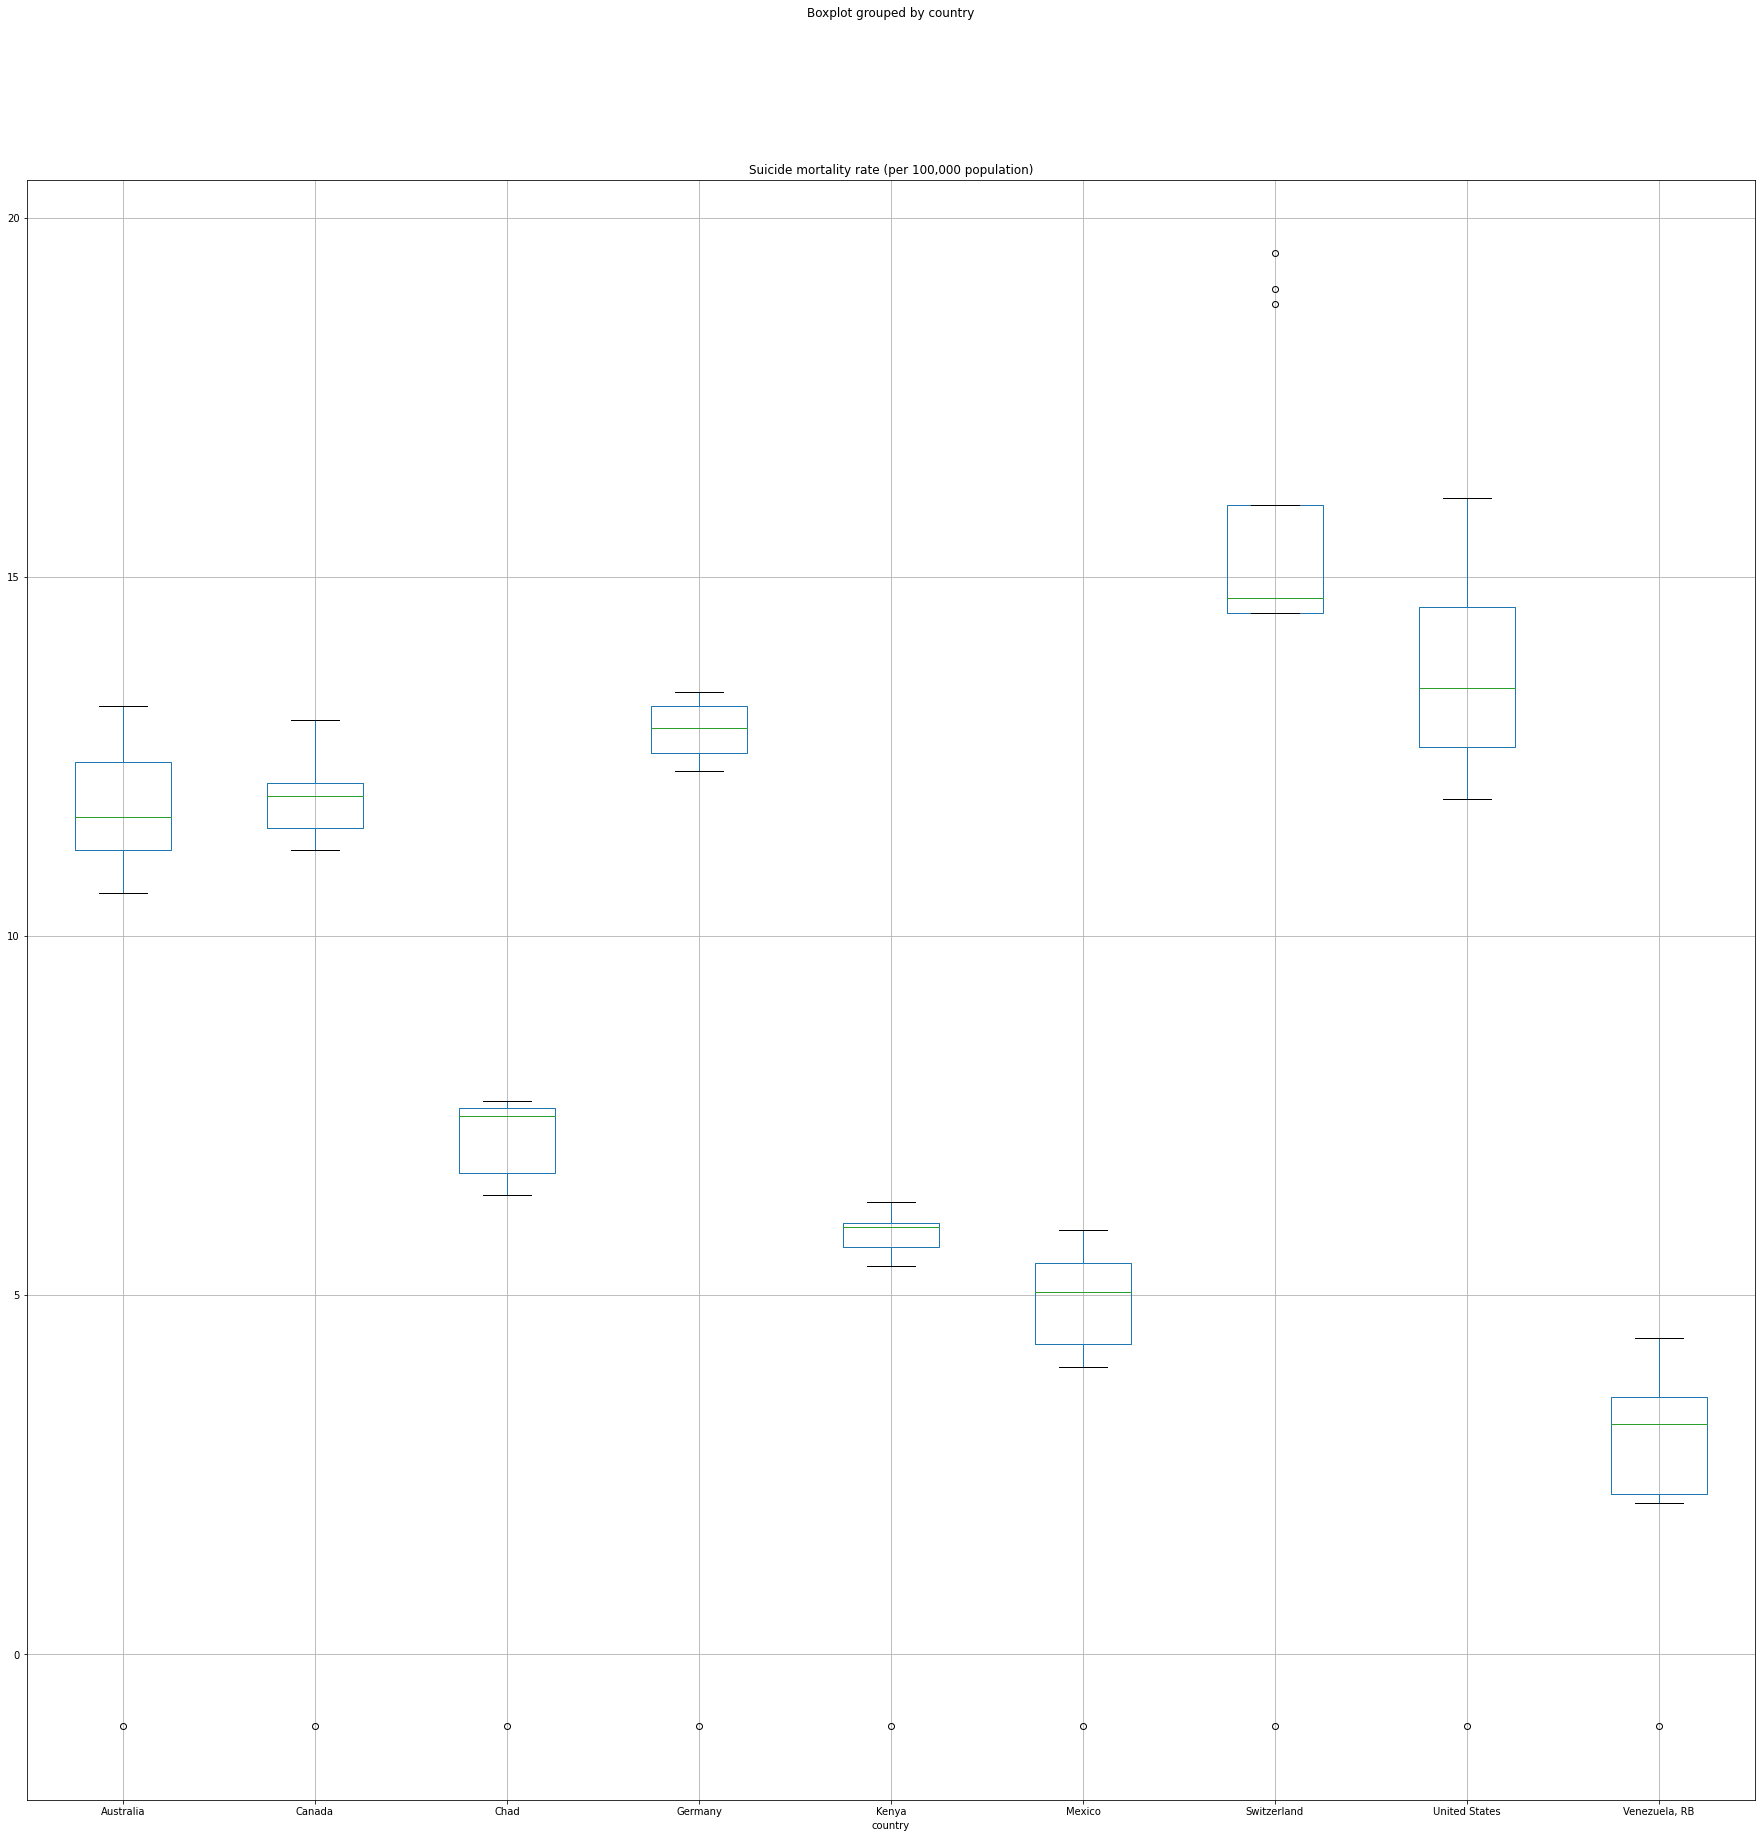

In [530]:
# Plotting boxplot of Suicide mortality rate by country 
suicide_mortality = base_df[["country", "Suicide mortality rate (per 100,000 population)"]]

# Making the column numeric
suicide_mortality["Suicide mortality rate (per 100,000 population)"] = suicide_mortality["Suicide mortality rate (per 100,000 population)"].astype(float)

suicide_mortality.boxplot(figsize=(30,30), column="Suicide mortality rate (per 100,000 population)", by="country")

#### Without Missing Points

<AxesSubplot:title={'center':'Suicide mortality rate (per 100,000 population)'}, xlabel='country'>

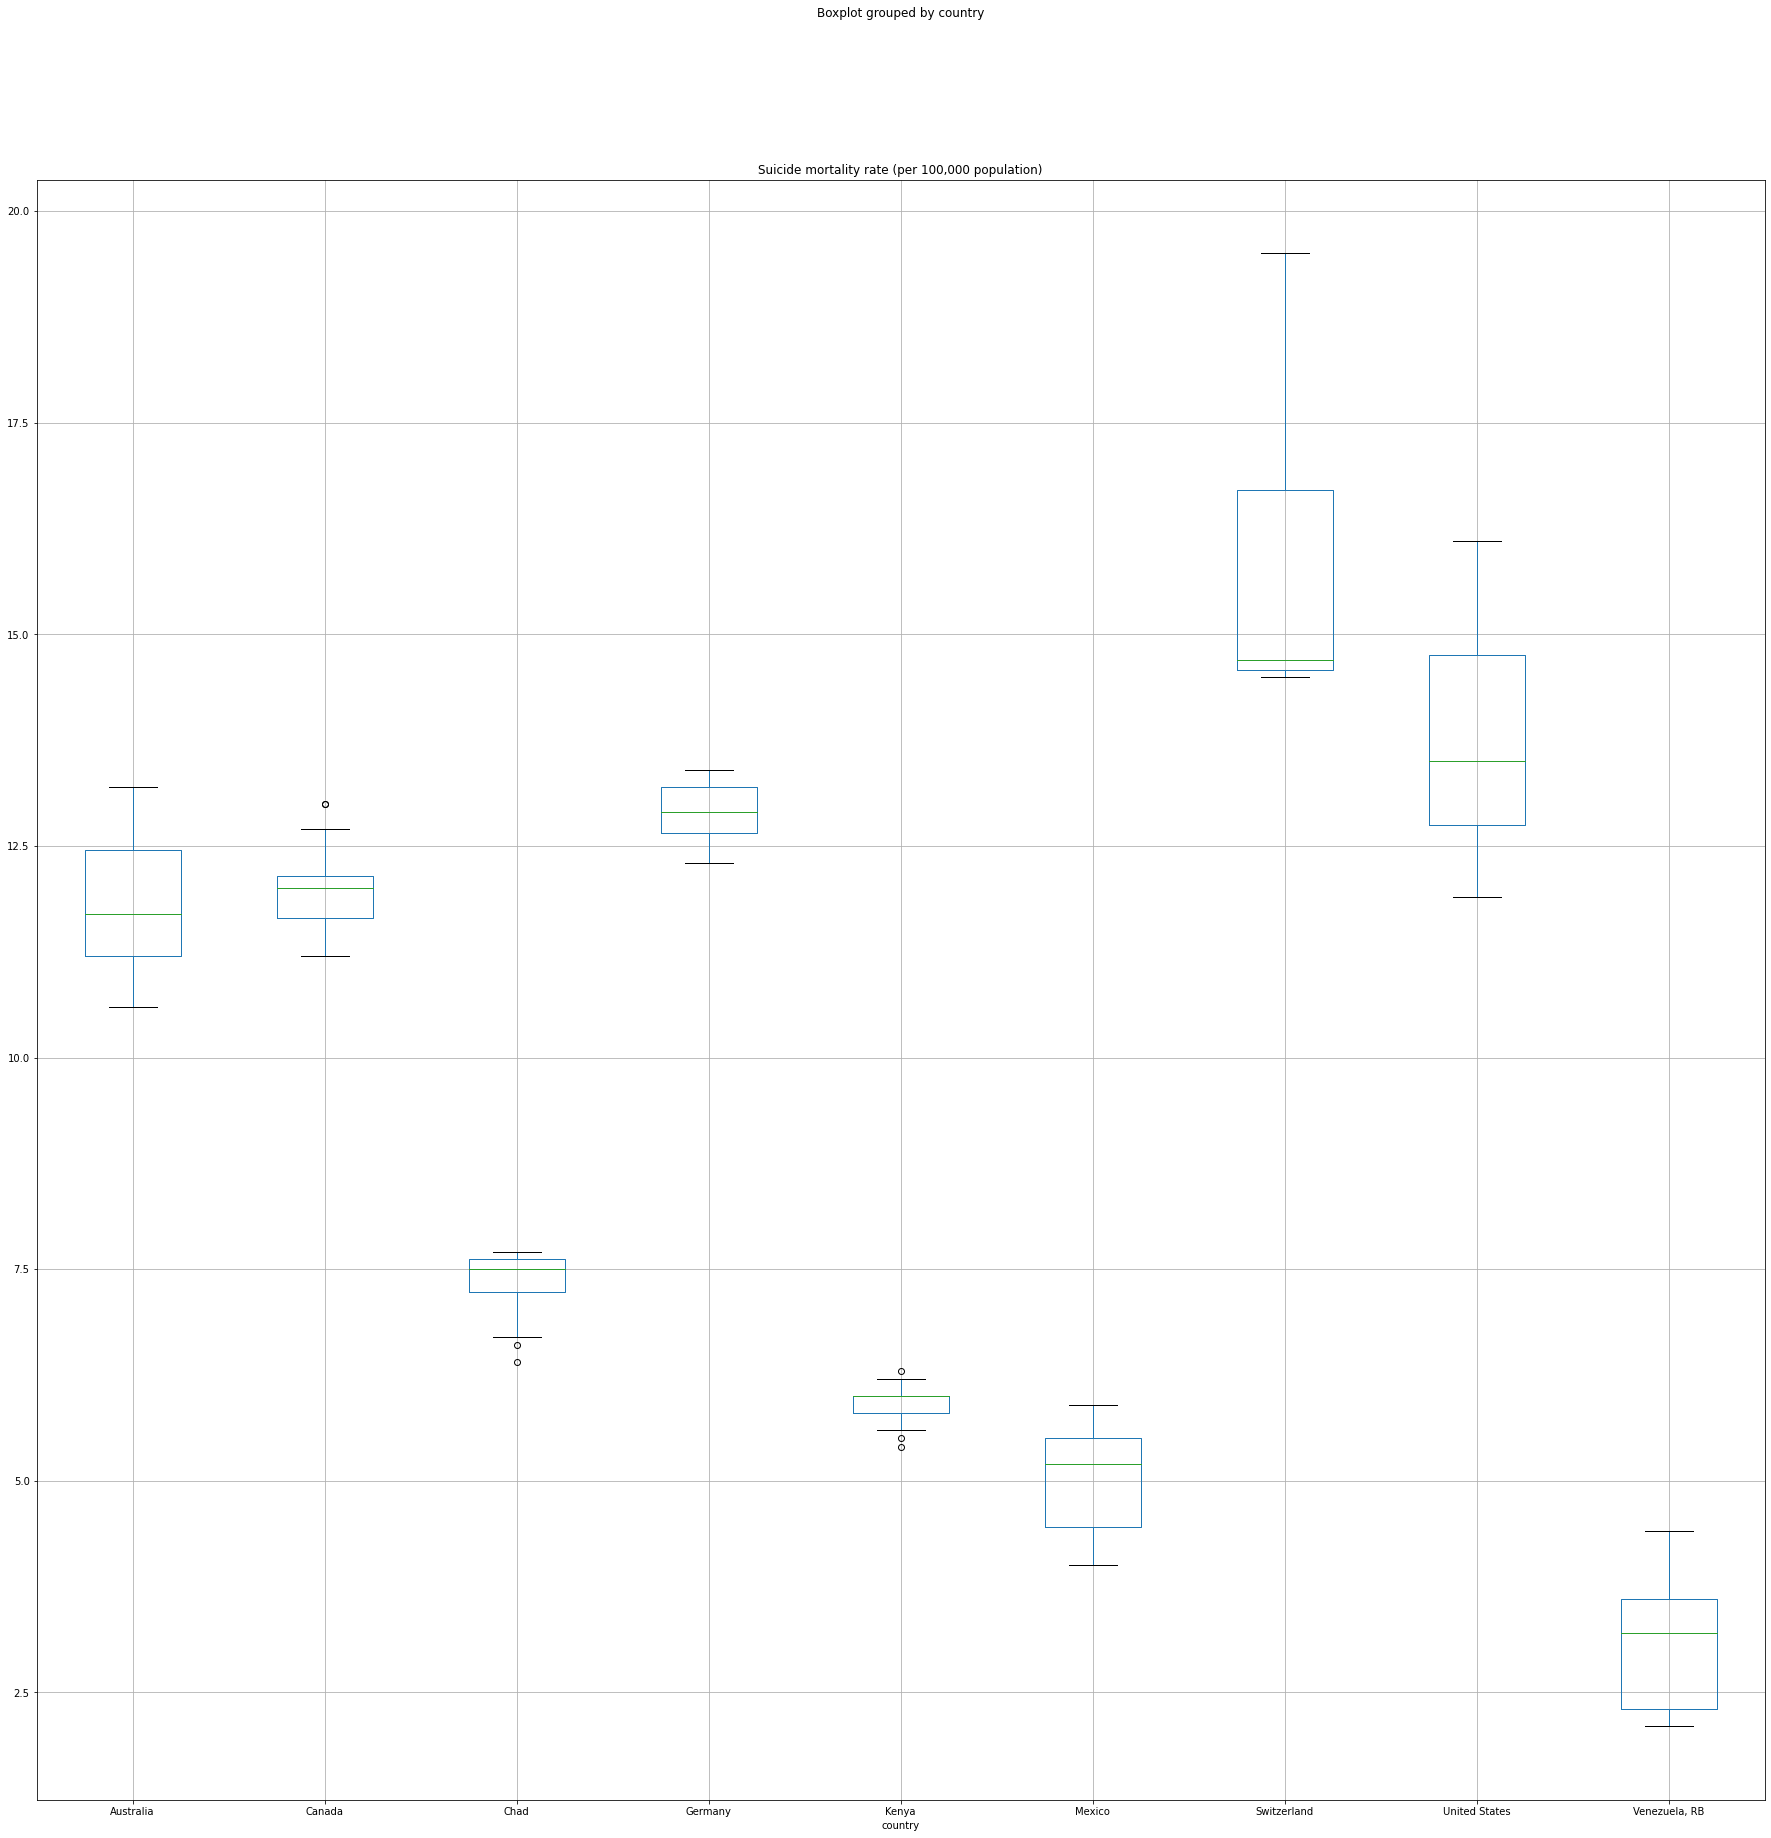

In [529]:
suicide_mortality["Suicide mortality rate (per 100,000 population)"] = label_transformer.fit_transform(suicide_mortality["Suicide mortality rate (per 100,000 population)"].to_numpy().reshape(-1,1))
suicide_mortality.boxplot(figsize=(30,30), column="Suicide mortality rate (per 100,000 population)", by="country")

### Scatter Plots 

<AxesSubplot:xlabel='Prevalence of overweight, female (% of female adults)', ylabel='Domestic general government health expenditure (% of GDP)'>

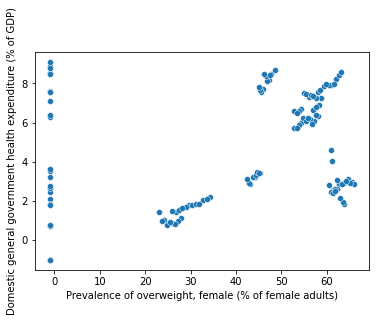

In [353]:
obesity_health_spending = base_df[["Prevalence of overweight, female (% of female adults)", 
                               "Domestic general government health expenditure (% of GDP)"]].astype(float)

# obesity_health_spending.plot(kind='scatter', y="Prevalence of overweight, female (% of female adults)", x="Domestic general government health expenditure (% of GDP)", color='b', title="Prevalance of Overweight and hypertension (F)")
sns.scatterplot(x="Prevalence of overweight, female (% of female adults)",y='Domestic general government health expenditure (% of GDP)', data=obesity_health_spending)

<AxesSubplot:xlabel='Prevalence of overweight, female (% of female adults)', ylabel='Domestic general government health expenditure (% of GDP)'>

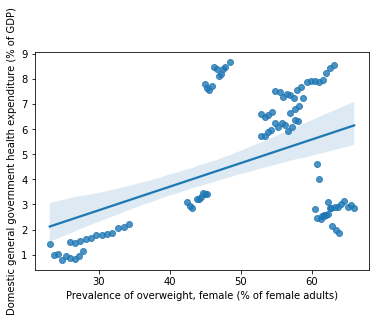

In [531]:
# What if we got rid of the missing values (-1) and plotted the linear regression.
obesity_health_spending = pd.DataFrame(data=label_transformer.fit_transform(obesity_health_spending),
                                       columns=["Prevalence of overweight, female (% of female adults)", 
                                                "Domestic general government health expenditure (% of GDP)"])
                                                
sns.regplot(x="Prevalence of overweight, female (% of female adults)", y='Domestic general government health expenditure (% of GDP)', data=obesity_health_spending)

### Histograms

<AxesSubplot:xlabel='Count', ylabel='HDI'>

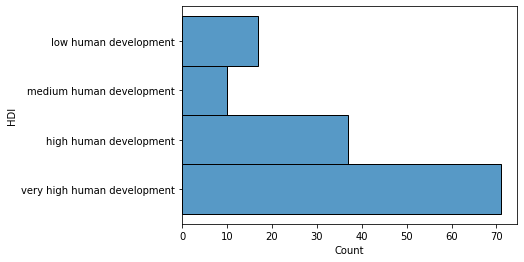

In [355]:
# Plotting the Histagram of HDI
hdi = pd.DataFrame(base_y)
sns.histplot(data=hdi, y='HDI')

<AxesSubplot:xlabel='Population growth (annual %)', ylabel='Count'>

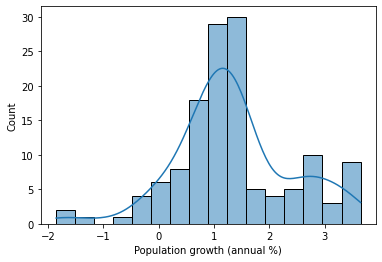

In [356]:
# Plotting the Histagram of Population Growth
population_growth = base_df["Population growth (annual %)"].astype(float)
sns.histplot(data=population_growth, kde=True)

## ML Time

In [519]:
# Models & Their Params
model_d_tree = DecisionTreeClassifier(random_state=41)
param_d_tree = [
    {
        'max_depth': [2, 3],
        'min_samples_split':[2, 5, 8]
    }
]

model_rand_forest = RandomForestClassifier(random_state=41)
param_rand_forest = [
    {
        'max_depth': [2, 3],
        'n_estimators': [5, 10, 25]
    }
]
model_grad_boost = GradientBoostingClassifier(learning_rate=0.01, random_state=41)
param_grad_boost = [
    {
        'max_depth': [2, 3],
        'n_estimators': [25, 40, 50]
    }
]

### Training

In [520]:

gscv_d_tree = GridSearchCV(estimator=model_d_tree, 
                           param_grid=param_d_tree, 
                           cv=3, 
                           return_train_score=True)

gscv_rand_forest = GridSearchCV(estimator=model_rand_forest, 
                                param_grid=param_rand_forest, 
                                cv=3, 
                                return_train_score=True)

gscv_grad_boost = GridSearchCV(estimator=model_grad_boost, 
                               param_grid=param_grad_boost, 
                               cv=3, 
                               return_train_score=True)

start = time.perf_counter()
gscv_d_tree.fit(X_train,y_train)
time_d_tree = time.perf_counter() - start
print(f"Decision Tree training took: {round(time_d_tree, 3)}s")

start = time.perf_counter()
gscv_rand_forest.fit(X_train,y_train)
time_rand_forest = time.perf_counter() - start
print(f"Random Forest training took: {round(time_rand_forest, 3)}s")

start = time.perf_counter()
gscv_grad_boost.fit(X_train,y_train)
time_grad_boost = time.perf_counter() - start
print(f"Gradient Boost training took: {round(time_grad_boost, 3)}s")


Decision Tree training took: 0.026s
Random Forest training took: 0.301s
Gradient Boost training took: 1.304s


### Visiualizing Decision Tree

In [518]:
text_tree = export_text(gscv_d_tree.best_estimator_, feature_names=COLS)
print(text_tree)

|--- Suicide mortality rate (per 100,000 population) <= 0.09
|   |--- Birth rate, crude (per 1,000 people) <= 0.59
|   |   |--- class: 2.0
|   |--- Birth rate, crude (per 1,000 people) >  0.59
|   |   |--- Birth rate, crude (per 1,000 people) <= 1.51
|   |   |   |--- class: 1.0
|   |   |--- Birth rate, crude (per 1,000 people) >  1.51
|   |   |   |--- class: 0.0
|--- Suicide mortality rate (per 100,000 population) >  0.09
|   |--- class: 3.0



### Confusion Matrix Heat Maps and Classification Reports

#### Decision Tree

Decision Tree Confusion Matrix Heat Map and Classification Report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      1.00      1.00         4
         2.0       1.00      1.00      1.00        13
         3.0       1.00      1.00      1.00        25

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



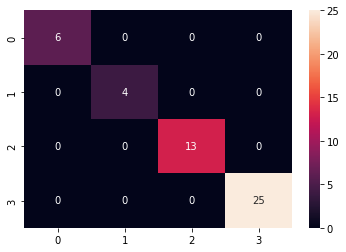

In [509]:
pred_d_tree = gscv_d_tree.best_estimator_.predict(X_test)
pred_rand_forest = gscv_rand_forest.best_estimator_.predict(X_test)
pred_grad_boost = gscv_grad_boost.best_estimator_.predict(X_test)

print("Decision Tree Confusion Matrix Heat Map and Classification Report")
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=pred_d_tree), annot=True)
print(classification_report(y_true=y_test, y_pred=pred_d_tree))

#### Random Forest

Random Forest Confusion Matrix Heat Map and Classification Report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      1.00      1.00         4
         2.0       1.00      1.00      1.00        13
         3.0       1.00      1.00      1.00        25

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



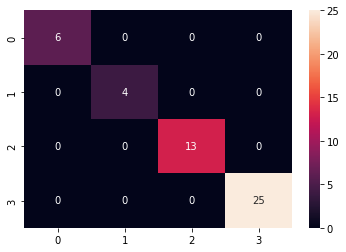

In [511]:
print("Random Forest Confusion Matrix Heat Map and Classification Report")
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=pred_rand_forest), annot=True)
print(classification_report(y_true=y_test, y_pred=pred_rand_forest))

#### Gradient Boost

Gradient Boost Confusion Matrix Heat Map and Classification Report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      0.75      0.86         4
         2.0       1.00      1.00      1.00        13
         3.0       0.96      1.00      0.98        25

    accuracy                           0.98        48
   macro avg       0.99      0.94      0.96        48
weighted avg       0.98      0.98      0.98        48



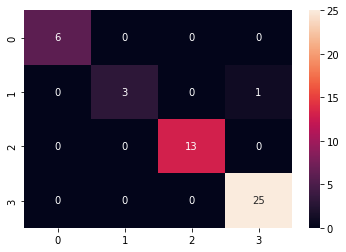

In [521]:
print("Gradient Boost Confusion Matrix Heat Map and Classification Report")
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=pred_grad_boost), annot=True)
print(classification_report(y_true=y_test, y_pred=pred_grad_boost))